In [1]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import matplotlib
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

from statsmodels.tsa.seasonal import STL
%matplotlib inline

init_notebook_mode(connected = True)

In [2]:
if os.path.exists('./city_temperature.csv'):
    df = pd.read_csv('./city_temperature.csv',low_memory=False)
    df['Date'] = pd.to_datetime(df.loc[:,'Month':'Year'],dayfirst=True,errors='coerce')

In [79]:
df_us = df[df['Country']=='US'].groupby([pd.Grouper(key='Date',freq='3M')]).mean().unstack(level=0).reindex().AvgTemperature
df_us.where(df_us>-99,inplace=True)

<AxesSubplot:xlabel='Date'>

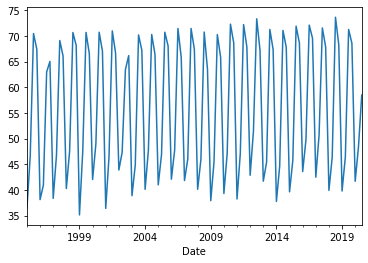

In [80]:
df_us.interpolate(method='time').plot()

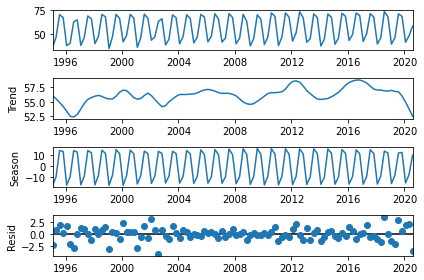

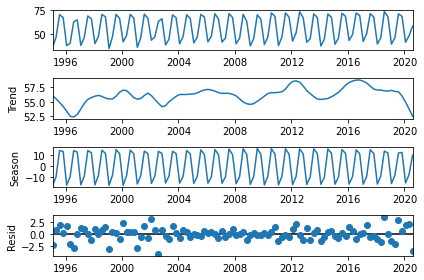

In [84]:
model = STL(df_us).fit()
# model = STL(df[['Date','AvgTemperature']].set_index('Date').resample('M').mean()).fit()
model.plot()

In [85]:
df_us.size

103

In [94]:
df[(df.Country=='US')&(df.AvgTemperature>-99)].size

13054995

In [107]:
df_all = df.groupby([pd.Grouper(key='Date',freq='Q')]).mean().unstack(level=0).reindex().AvgTemperature
df_all.where(df_us>-99,inplace=True)

<AxesSubplot:xlabel='Date'>

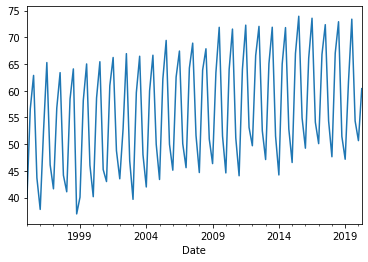

In [108]:
df_all.interpolate(method='time').plot()

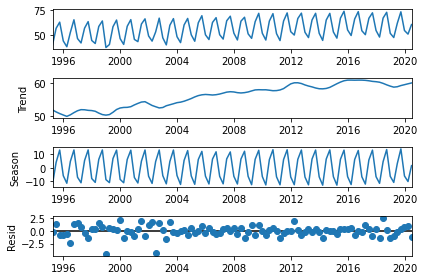

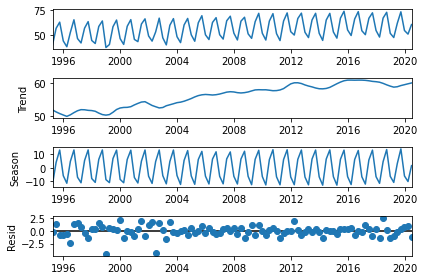

In [109]:
model = STL(df_all).fit()
model.plot()

In [110]:
df_all

Date
1995-03-31    39.836740
1995-06-30    56.580747
1995-09-30    62.871896
1995-12-31    43.685970
1996-03-31    37.779504
                ...    
2019-06-30    61.712675
2019-09-30    73.406847
2019-12-31    54.348058
2020-03-31    50.660205
2020-06-30    60.395089
Length: 102, dtype: float64